In [1]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.


In [2]:
!pip install -qq transformers

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 54.9 MB/s 
     |████████████████████████████████| 67 kB 5.8 MB/s 
     |████████████████████████████████| 596 kB 73.9 MB/s 
     |████████████████████████████████| 895 kB 69.6 MB/s 


In [3]:
'''Import libraries'''

# Basic
from random import randint
import numpy as np
import pandas as pd
from collections import defaultdict
from textwrap import wrap
import os

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Graphic
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# Presets
sns.set(style='darkgrid', palette='bright', font_scale=1.2)
rcParams['figure.figsize'] = 10, 5
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
PRE_TRAINED_MODEL_NAME = 'DeepPavlov/rubert-base-cased-sentence'

if '.config' in os.listdir(): # check if we at local PC
  from google.colab import drive
  drive.mount('/content/drive')
  path = "drive/MyDrive/Colab Notebooks/Diplom/project/"
    
else: 
  path = ''

# Check GPU 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cuda', index=0)

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.15.0



## Defining functions and classes

In [5]:
'''This function will combine two worst classes,
to smooth out uneven distribution:'''

def rating_recount(x):  
    if x <= 2:
        return 0
    elif x == 3:
        return 1
    elif x == 4:
        return 2    

In [6]:
'''Class with nlp model'''

class TransformerModel(nn.Module):

    def __init__(self, n_classes):
        super(TransformerModel, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,
                                              return_dict=False)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [7]:
'''This class will prepare our data to feed the model'''

class RatingDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True )

        return {'review_text': review,'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)}

In [8]:
'''It's global class to work with text rating prediction 
from preparing raw data for the model to evaluating the results'''

class RatingClassifier():
    
    def __init__(self,class_names = ['negative', 'neutral', 'positive']):
        self.class_names = class_names # User may change class quantity and names
        self.tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    
    # This will create data loaders to feed the model
    def create_data_loader(self,df, tokenizer, max_len, batch_size):
    
        ds = RatingDataset(reviews=df.text.to_numpy(),
                           targets=df.rating.to_numpy(),
                           tokenizer=tokenizer,
                           max_len=max_len)
        
        return DataLoader(ds,batch_size=batch_size,num_workers=2)  
        
    # Train model foe one epoch
    def train_epoch(self,model,data_loader,loss_fn,optimizer, 
                device,scheduler,n_examples):
        model = model.train()
        losses = []
        correct_predictions = 0

        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        return correct_predictions.double() / n_examples, np.mean(losses)
    
    # Evaluating epoch results
    def eval_model(self,model, data_loader, loss_fn, device, n_examples):
        model = model.eval()

        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for d in data_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                _, preds = torch.max(outputs, dim=1)

                loss = loss_fn(outputs, targets)

                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)
    
    # Fit the model
    def fit(self,dataset, train_size = 0.8, # Here we can change train size 
            model_name ='Untitled'): # and model name to save the results
    
        # Splitting data
        df_train, df_test = train_test_split(dataset,
                                         train_size=train_size,
                                         stratify = dataset.rating,
                                         random_state=RANDOM_SEED)
        df_val, df_test = train_test_split(df_test, test_size=0.5,
                                           stratify = df_test.rating,
                                           random_state=RANDOM_SEED)
        
        # Checking shapes:
        print(f' Train shape: {df_train.shape}\n',
          f'Validation shape: {df_val.shape}\n',
          f'Test shape: {df_test.shape}')

        # Make loaders
        train_data_loader = self.create_data_loader(df_train, self.tokenizer, 
                                               MAX_LEN, BATCH_SIZE)
        val_data_loader = self.create_data_loader(df_val, self.tokenizer, 
                                             MAX_LEN, BATCH_SIZE)
        self.test_data_loader = self.create_data_loader(df_test, self.tokenizer, 
                                              MAX_LEN, BATCH_SIZE)

        # Forward data to device 
        data = next(iter(train_data_loader))
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        
        self.model = TransformerModel(len(self.class_names))
        self.model = self.model.to(device)
        # Add softmax layer to split results by categories:
        F.softmax(self.model(input_ids, attention_mask), dim=1)
        # This parameters are adviced by developers:    
        optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        loss_fn = nn.CrossEntropyLoss().to(device)
        total_steps = len(train_data_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
            )

        self.history = defaultdict(list)# here metrics will be saved
        best_accuracy = 0# This is to choose the best model
        # Trainging... 
        for epoch in range(EPOCHS):

            print(f'Epoch {epoch + 1}/{EPOCHS}')
            print('-' * 10)

            train_acc, train_loss = self.train_epoch(
                self.model, train_data_loader,    
                loss_fn,optimizer, 
                device, scheduler,len(df_train))

            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval_model(
                self.model, val_data_loader,
                loss_fn, device, len(df_val))

            print(f'Val   loss {val_loss} accuracy {val_acc}')
            print()
            # Saving metrics
            self.history['train_acc'].append(train_acc)
            self.history['train_loss'].append(train_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_loss'].append(val_loss)

            if val_acc > best_accuracy:# Save best model
                torch.save(self.model.state_dict(),
                           f'{path}{model_name}.bin')
                best_accuracy = val_acc
           
        self.show_report()# Show classification report 
    
    def plot_history(self):# Visualize training process
        try:
            plt.plot(self.history['train_acc'],color = 'b', label='train accuracy')
            plt.plot(self.history['val_acc'], color = 'g', label='validation accuracy')
            plt.title('Training history')
            plt.ylabel('Accuracy')
            plt.xlabel('Epoch')
            plt.legend()
            plt.ylim([0.5, 1])
        
        except AttributeError:# operate the error if model hasn't been trained:
            print("Fit model at first!") 
    
    def show_report(self):# Use sklearn library to show metrics
        try:
            model = self.model.eval()

            self.review_texts = []
            predictions = []
            prediction_probs = []
            real_values = []

            with torch.no_grad():
                for d in self.test_data_loader:

                    texts = d["review_text"]
                    input_ids = d["input_ids"].to(device)
                    attention_mask = d["attention_mask"].to(device)
                    targets = d["targets"].to(device)

                    outputs = model(input_ids=input_ids,
                                    attention_mask=attention_mask)
                    _, preds = torch.max(outputs, dim=1)

                    probs = F.softmax(outputs, dim=1)

                    self.review_texts.extend(texts)
                    predictions.extend(preds)
                    prediction_probs.extend(probs)
                    real_values.extend(targets)

            self.predictions = torch.stack(predictions).cpu()
            self.prediction_probs = torch.stack(prediction_probs).cpu()
            self.real_values = torch.stack(real_values).cpu()

            print('Classification Report\n')
            print(classification_report(self.real_values, self.predictions,
                                        target_names=self.class_names))
        except AttributeError:
            print("Fit model at first!")
    
    # The most descriptive visualization for classifying models
    def show_confusion_matrix(self):
        try:    
            cm = confusion_matrix(self.real_values, self.predictions)
            df_cm = pd.DataFrame(cm, index=self.class_names, columns=self.class_names)

            hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
            hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
            hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
            plt.ylabel('True rating')
            plt.xlabel('Predicted rating')
    
        except AttributeError:
            print("Fit model at first!")
    
    # This method shows us text from dataset and it's class probability
    def show_probability(self,index):
        try:
        
            pred_df = pd.DataFrame({'class_names': self.class_names,
                                    'values': self.prediction_probs[index]})

            print("\n".join(wrap(self.review_texts[index])))
            print()
            print(f'True rating: {self.class_names[self.real_values[index]]}')
            sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
            plt.ylabel('rating')
            plt.xlabel('probability')
            plt.xlim([0, 1])
        
        except AttributeError:
            print("Fit model at first!")
    
    # Predicing the class of random text: 
    def predict(self,text):
        try:
            encoded_review = self.tokenizer.encode_plus(
              text,
              max_length=MAX_LEN,
              add_special_tokens=True,
              return_token_type_ids=False,
              pad_to_max_length=True,
              return_attention_mask=True,
              return_tensors='pt',
              padding='max_length',
              truncation=True     
            )

            input_ids = encoded_review['input_ids'].to(device)
            attention_mask = encoded_review['attention_mask'].to(device)

            output = self.model(input_ids, attention_mask)
            _, prediction = torch.max(output, dim=1)
        
        except AttributeError:
            print("Fit model at first!")
        
        return int(prediction) 
    
    # load early saved model parameters
    def load_model(self,file_name):
           
        self.model = TransformerModel(len(self.class_names))
        self.model.load_state_dict(torch.load(file_name))
        self.model = self.model.to(device)
    
    # This visualisation will help us in choosing the length to cut the sentense
    def show_sentenses_lengths(self,series,max_length = 500):

        token_lenghts = []

        for txt in series:
            tokens = self.tokenizer.encode(txt, max_length=max_length,
                                           truncation=True)
            token_lenghts.append(len(tokens))

        sns.displot(token_lenghts)
        plt.xlim([0, max_length + 100])
        plt.xlabel('Sentense length')   


##EDA

In [9]:
'''Let's look on the dataset: '''
main_reviews = pd.read_csv(path+'data/reviews/main_reviews.csv')
main_reviews.sample(10)

,id,date,text,likes,dislikes,rating,product
169,HP-PROBOOK-450-G6,29 июня 2020,Офисный ноут - оправдывает название. Подходит ...,4,0,3,notebooks
14332,INNO3D-GEFORCE-RTX-3070-ICHILL-X3,10 ноября 2020,"хорошая модель, понравилось# Хорошая модельБыс...",1,0,3,video
2501,TOSHIBA-HDWR480UZSVA,17 сентября,"Если готовы терпеть вой от 7200 RPM, то можно ...",0,0,2,hdd
9940,A-DATA-AX4U320038G16A-DR41,29 мая 2021,Отличная оперативка за свои деньги# XMP профил...,0,0,4,ram
1123,AEROCOOL-AERO-ONE-ECLIPSE-4710562752342,29 марта 2021,"отличная модель, очень понравилось# Черный С с...",0,0,4,case
11123,PATRIOT-MEMORY-PVB416G360C7K,15 декабря,"Чипы Hynix C-die, хорошо гонится, 3800 Мгц с R...",0,0,4,ram
1475,AEROCOOL-AERO-ONE-4710562752311,27 ноября 2020,Неплохой выбор за свою цену# Собрал я значит с...,1,0,3,case
6137,GAMEMAX-GP-500,12 ноября 2017,Не рекомендую. Лучше добавить 1 - 1.5к и купит...,3,2,2,power
8620,AMD-1600-OEM-14-NM,15 декабря 2018,"хорошая модель, понравилось# Разница по цене у...",8,3,3,proc
8267,AMD-7702P-BOX,4 ноября,за свои деньги норм# впринцепе норм проц кибер...,1,0,3,proc


In [ ]:
main_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14568 entries, 0 to 14567
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        14568 non-null  object
 1   date      14568 non-null  object
 2   text      14568 non-null  object
 3   likes     14568 non-null  int64 
 4   dislikes  14568 non-null  int64 
 5   rating    14568 non-null  int64 
 6   product   14568 non-null  object
dtypes: int64(3), object(4)
memory usage: 796.8+ KB


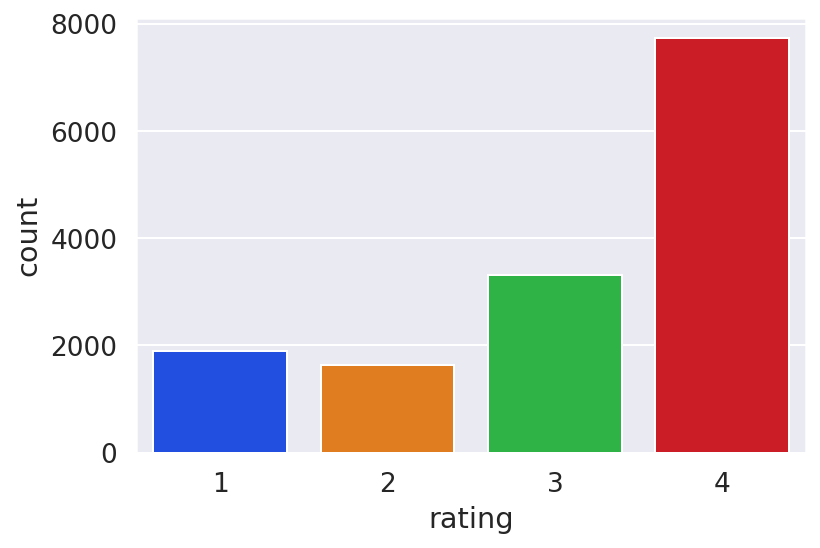

In [ ]:
'''From the graphic we can see that the class distribution
is strongly uneven'''

sns.countplot(x = main_reviews.rating)

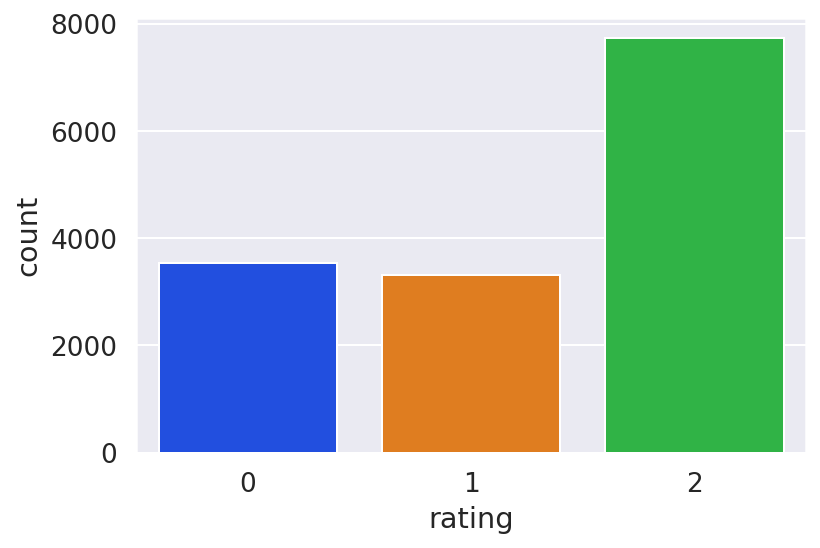

In [ ]:
'''Smoothing out the uneven distribution'''
main_reviews.rating = main_reviews.rating.apply(rating_recount)
sns.countplot(x = main_reviews.rating)

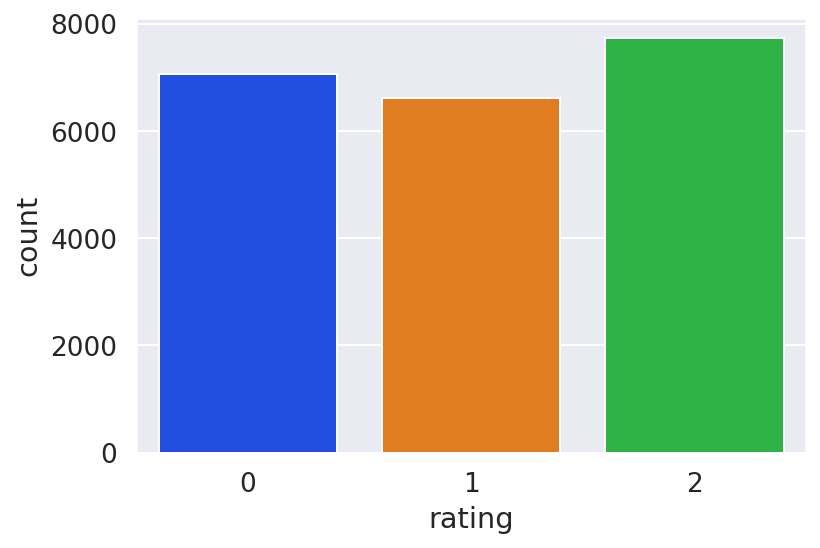

In [ ]:
'''The classes are still highly uneven, 
here I'll use the oversampling method to fix this:'''
oversample = main_reviews.append(main_reviews[main_reviews.rating <2],
                                 ignore_index = True)
sns.countplot(x = oversample.rating)

## Training models

#### Oversample model

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

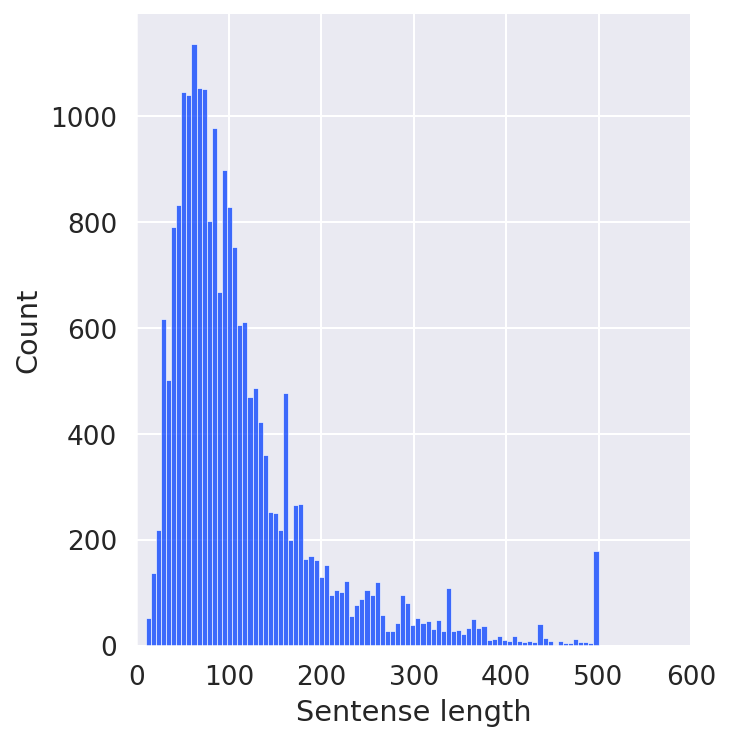

In [ ]:
'''Create classifier and draw graphc to choose the maximum 
lenght of the sentenses in our texts:'''
oversample_model = RatingClassifier()
oversample_model.show_sentenses_lengths(oversample.text) 

In [ ]:
!nvidia-smi

Wed Jan 12 06:39:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%time
'''Training the model'''
MAX_LEN = 300
BATCH_SIZE = 16
EPOCHS = 3

oversample_model.fit(oversample[['text','rating']],model_name = 'oversample')


 Train shape: (17125, 2)
 Validation shape: (2141, 2)
 Test shape: (2141, 2)


Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

Epoch 1/3
----------
Train loss 0.3167375942781728 accuracy 0.8803503649635037
Val   loss 0.12438033455148784 accuracy 0.9677720691265763

Epoch 2/3
----------
Train loss 0.08650431187142314 accuracy 0.9806131386861314
Val   loss 0.1180627200311161 accuracy 0.9789817842129845

Epoch 3/3
----------
Train loss 0.02952067383126848 accuracy 0.9945109489051095
Val   loss 0.11637244804948221 accuracy 0.9813171415226529

Classification Report

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       706
     neutral       0.96      0.98      0.97       662
    positive       0.99      0.97      0.98       773

    accuracy                           0.98      2141
   macro avg       0.98      0.98      0.98      2141
weighted avg       0.98      0.98      0.98      2141

CPU times: user 1h 31min 46s, sys: 1min 47s, total: 1h 33min 34s
Wall time: 1h 33min 46s


It's quite good results for our business task, because we need the maximum recall for negative group and highest precision for positive  

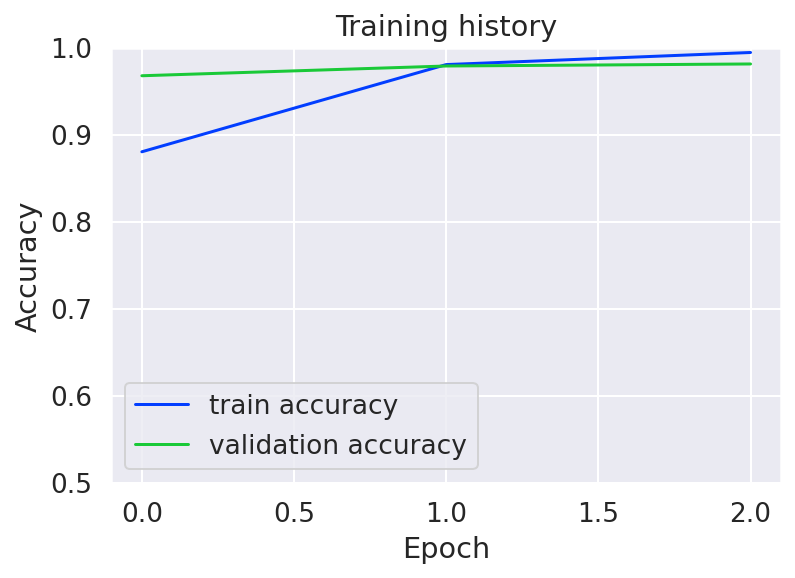

In [ ]:
oversample_model.plot_history()

Model overfits very quickly, but increasing the Dropout is not a good idea, especially while we've reached such a fine results

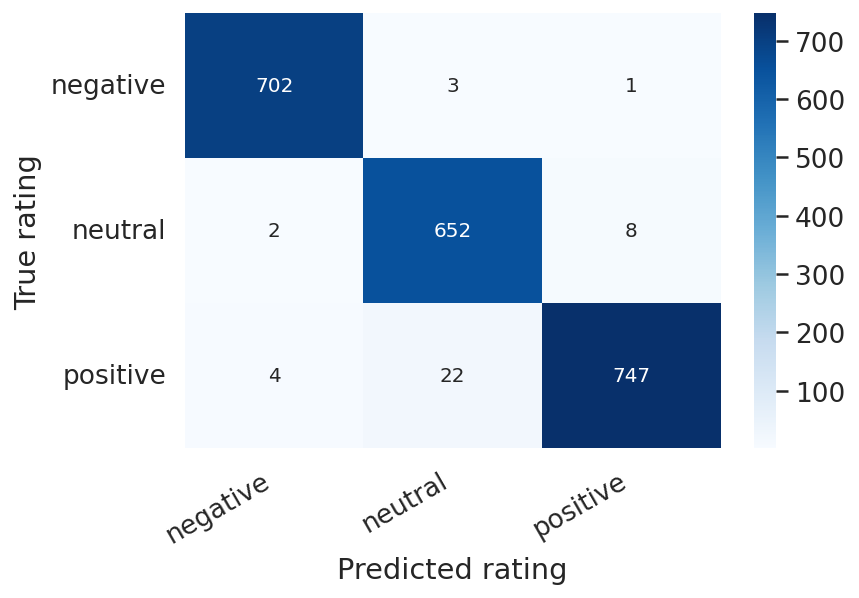

In [ ]:
oversample_model.show_confusion_matrix()

The model practically doesn't recognize negative as positive and this is good 

Отличный кулер. Рекомендую.# Искал кулер для LGA1700 и в продаже были
только ID-Cooling и Thermaltake. До этого не слышал про эту фирму и
решил попробовать, тем более что он на 1000 ₽ дешевле, чем Tt. MB:
Gigabyte Z690 GAMING X DDR4 CPU: Intel Core i5-12600K Всегда был
противником подсветок, но ARGB очень понравилось.— цена — дизайн —
компактность — тишинаДля установки нужна крестовая отвертка длиной
15-20 см. Без нее будет очень сложно. Имейте в виду.Денис Никитин:

True rating: positive


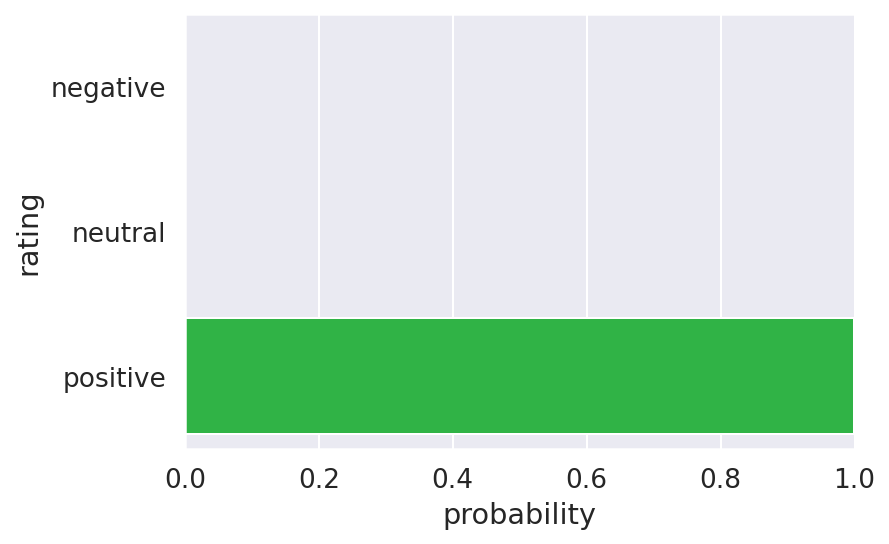

In [ ]:
'''You can run the cell several times to see the random text
and it's prediction probability''' 
random_index = randint(0,len(oversample_model.review_texts))
oversample_model.show_probability(random_index)

In [ ]:
'''Here the examples of models predictions:'''

text_1 = 'Берите, не пожалеете'
text_2 = 'Если доработать, то хорошая '
text_3 = 'Я бы брать не стал'

for text in [text_1,text_2,text_3]:
    pred = oversample_model.predict(text)
    print(f'Models predict for text: {text}\nis {oversample_model.class_names[pred]}')

Models predict for text: Берите, не пожалеете
is positive
Models predict for text: Если доработать, то хорошая 
is neutral
Models predict for text: Я бы брать не стал
is negative


In [ ]:
'''Clearing memory: '''
del oversample_model
torch.cuda.empty_cache()

#### Undersample model

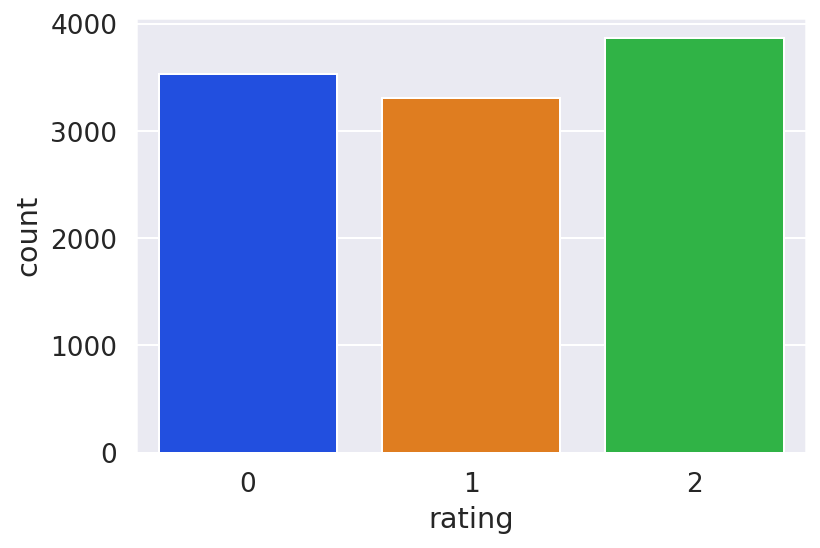

In [ ]:
'''Creating the undersample dataset'''
half = len(main_reviews[main_reviews.rating >1])//2
undersample = main_reviews[main_reviews.rating <2].append(
              main_reviews[main_reviews.rating >1].iloc[0:half])
sns.countplot(x = undersample.rating)

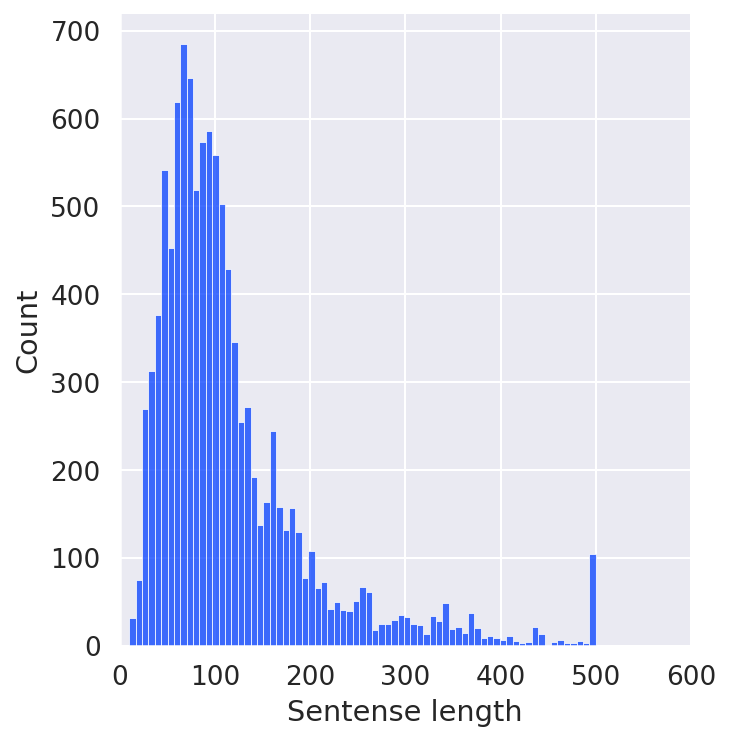

In [ ]:
'''Look at lengths'''
undersample_model = RatingClassifier()
undersample_model.show_sentenses_lengths(undersample.text) 

In [ ]:
%%time
'''Fitting...'''
MAX_LEN = 300
BATCH_SIZE = 16
EPOCHS = 3

undersample_model.fit(undersample[['text','rating']],model_name = 'undersample')

 Train shape: (8562, 2)
 Validation shape: (1070, 2)
 Test shape: (1071, 2)
Epoch 1/3
----------
Train loss 0.4321831547735092 accuracy 0.8244569025928521
Val   loss 0.24981029604130717 accuracy 0.9186915887850468

Epoch 2/3
----------
Train loss 0.1504728668875412 accuracy 0.95760336370007
Val   loss 0.2921081492017065 accuracy 0.9373831775700935

Epoch 3/3
----------
Train loss 0.070262027108597 accuracy 0.9844662462041579
Val   loss 0.322297875053569 accuracy 0.9401869158878505

Classification Report

              precision    recall  f1-score   support

    negative       0.98      0.96      0.97       353
     neutral       0.91      0.94      0.92       331
    positive       0.95      0.93      0.94       387

    accuracy                           0.94      1071
   macro avg       0.94      0.95      0.94      1071
weighted avg       0.95      0.94      0.95      1071

CPU times: user 45min 59s, sys: 53.8 s, total: 46min 53s
Wall time: 46min 58s


previous model showed us better results

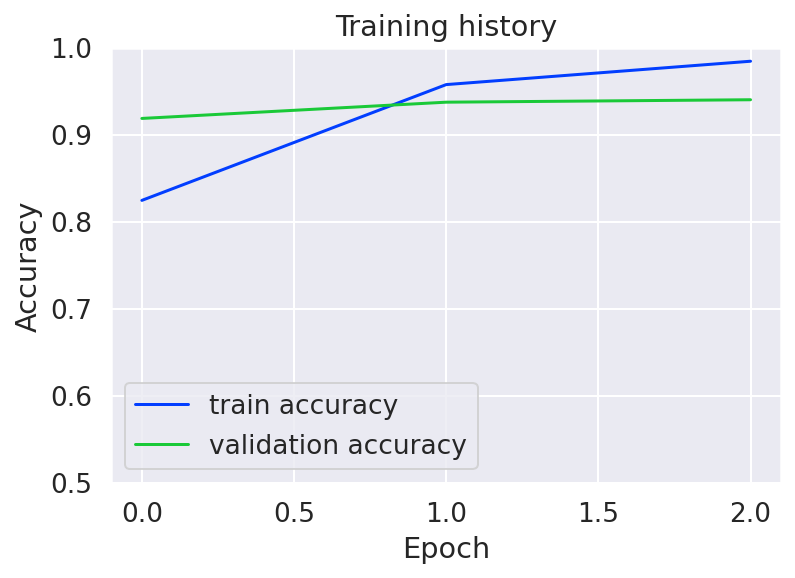

In [ ]:
'''It's overfitting even faster''' 
undersample_model.plot_history()

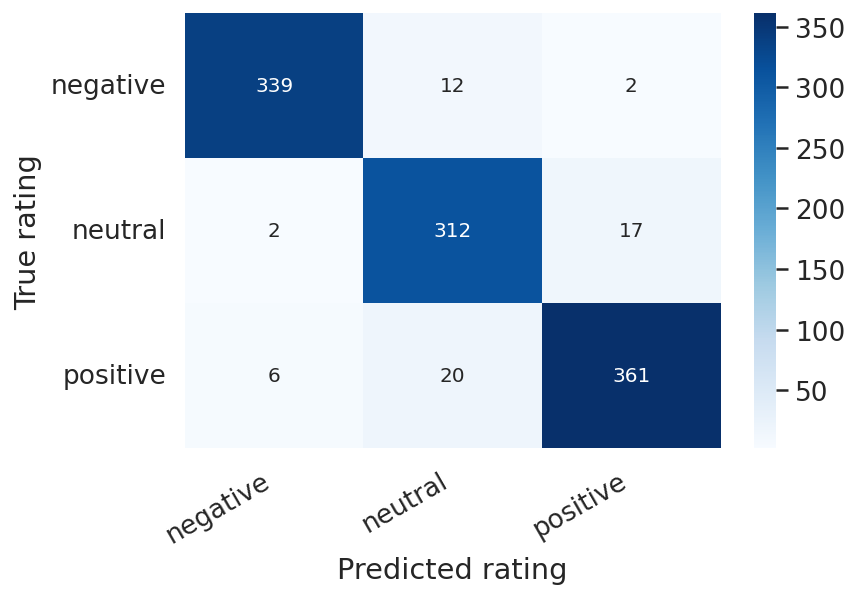

In [ ]:
undersample_model.show_confusion_matrix()

Some negative reviews were marked as positive, wich is not satisfying result

отличная модель, очень понравилось# Отличная материнкаВсе работает
прекрасно, первым "рекордом" стала память 4500 на сл16 с напряжением
1,5Не вижу надобности в подсветке, можно было бы ее сюда и не пихать
ибо она не такая яркая и под видюхой её особо не видноNonsense:

True rating: positive


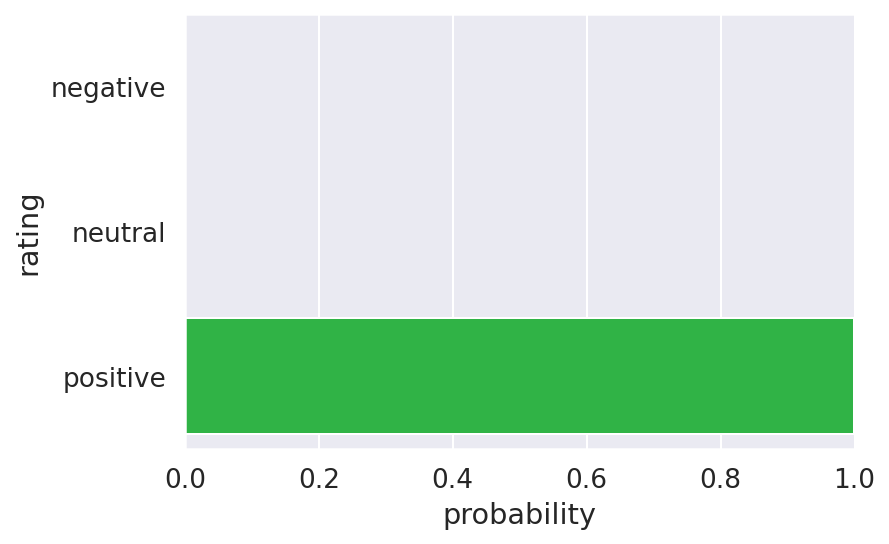

In [ ]:
random_index = randint(0,len(undersample_model.review_texts))
undersample_model.show_probability(random_index)

In [ ]:
text_1 = 'Берите, не пожалеете'
text_2 = 'Если доработать, то хорошая '
text_3 = 'Я бы брать не стал'

for text in [text_1,text_2,text_3]:
    pred = undersample_model.predict(text)
    print(f'Models predict for text: {text}\nis {undersample_model.class_names[pred]}')

Models predict for text: Берите, не пожалеете
is positive
Models predict for text: Если доработать, то хорошая 
is neutral
Models predict for text: Я бы брать не стал
is negative


In [ ]:
'''Clearing memory: '''
del undersample_model
torch.cuda.empty_cache()